## Анализ результатов АБ-теста

В этом задании мы:
* проанализируем АБ-тест, проведенный на реальных пользователях Яндекса
* оценим наличие изменений в пользовательском поведении между контрольной и тестовой группами
* определим характер этих изменений и практическую значимость вводимого изменения
* поймем, какая из пользовательских групп в большей степени проигрывает/выигрывает от тестируемого изменения

**Описание  данных:**

* **userID**:  уникальный идентификатор пользователя, данные с повторениями
* **browser**:  браузер, который использовал userID
* **slot**: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control  = видел неизменную страницу)
* **n_clicks**: количество кликов, которые пользоваль совершил за n_queries
* **n_queries**: количество запросов, который совершил userID, пользуясь браузером browser
* **n_nonclk_queries**: количество запросов пользователя, в которых  им не было совершено ни одного клика

Основная метрика, на которой мы сосредоточимся в этой работе — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы. 

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.pyplot as plt

In [10]:
data = pd.read_csv('ab_browser_test.csv')

In [11]:
data.head(20)

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30
5,8,Browser #4,control,4,4,1
6,9,Browser #4,exp,6,3,1
7,10,Browser #4,control,22,15,2
8,13,Browser #14,exp,2,4,3
9,15,Browser #14,control,2,2,0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566134 entries, 0 to 566133
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   userID            566134 non-null  int64 
 1   browser           566134 non-null  object
 2   slot              566134 non-null  object
 3   n_clicks          566134 non-null  int64 
 4   n_queries         566134 non-null  int64 
 5   n_nonclk_queries  566134 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 25.9+ MB


Посчитаем, насколько в группе ***exp*** больше пользовательских кликов по сравнению с группой ***control*** в процентах от числа кликов в контрольной группе. Результат округлим до 3-го знака после точки.

In [13]:
exp_clicks_sum = data[data['slot'] == 'exp']['n_clicks'].sum()
control_clicks_sum = data[data['slot'] == 'control']['n_clicks'].sum()
print(np.round(((exp_clicks_sum - control_clicks_sum)/control_clicks_sum)* 100, 3))

1.614


Попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов. Построим с помощью бутстрепа 95% доверительный интервал для средних значений медиан количества кликов в каждой из двух групп.

In [14]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [15]:
# построим бутстреп для средних
np.random.seed(0)

exp_clicks = data[data['slot'] == 'exp']['n_clicks'].values
control_clicks = data[data['slot'] == 'control']['n_clicks'].values

exp_mean_scores = list(map(np.mean, get_bootstrap_samples(exp_clicks, 1000)))
control_mean_scores = list(map(np.mean, get_bootstrap_samples(control_clicks, 1000)))

print('95% confidence interval for the exp mean repair clicks:',  stat_intervals(exp_mean_scores, 0.05))
print('95% confidence interval for the control mean repair clicks:',  stat_intervals(control_mean_scores, 0.05))

95% confidence interval for the exp mean repair clicks: [11.5086867  11.66089388]
95% confidence interval for the control mean repair clicks: [11.20795095 11.35742732]


In [16]:
# построим бутстреп для медиан
np.random.seed(0)

exp_clicks = data[data['slot'] == 'exp']['n_clicks'].values
control_clicks = data[data['slot'] == 'control']['n_clicks'].values

exp_median_scores = list(map(np.median, get_bootstrap_samples(exp_clicks, 1000)))
control_median_scores = list(map(np.median, get_bootstrap_samples(control_clicks, 1000)))

print('95% confidence interval for the exp median repair clicks:',  stat_intervals(exp_median_scores, 0.05))
print('95% confidence interval for the control median repair clicks:',  stat_intervals(control_median_scores, 0.05))

95% confidence interval for the exp median repair clicks: [5. 5.]
95% confidence interval for the control median repair clicks: [4. 4.]


Мы видим, что 95% доверительный интервал для разности средних не содержит ноль, что может говорить о том, что средние отличаются статистически значимо. То же можно сказать и про медианы.

Проверим, можем ли мы применить t-критерий Стьюдента. Так как мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия.
Для этого получим из данных n псевдовыборок. По каждой из этих выборок посчитаем среднее и сумму квадратов отклонения от выборочного среднего. Затем построим для получившегося вектора qq-plot для нормального распределения и для хи-квадрат распределения.

In [17]:
np.random.seed(0)
n_boot_samples = 500
control_samples = get_bootstrap_samples(control_clicks, n_boot_samples)
control_samples_mean = list(map(np.mean, control_samples))
control_boot_chi_squared = list(map(np.std, control_samples))

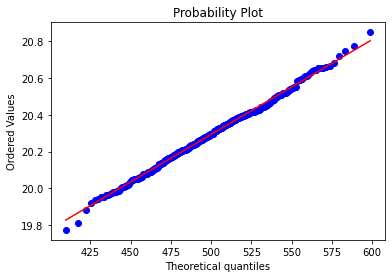

In [18]:
chi_plot = scipy.stats.probplot(control_boot_chi_squared, dist='chi2', 
                     sparams=(n_boot_samples-1), plot=plt)

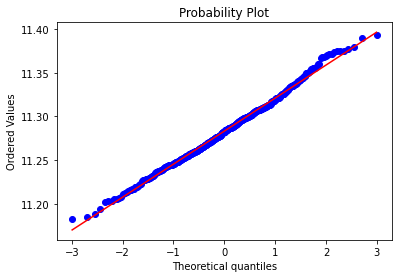

In [19]:
norm_plot = scipy.stats.probplot(control_samples_mean, dist='norm', plot=plt)

In [20]:
print('Mean R^2: %f' % norm_plot[1][2])

Mean R^2: 0.997975


In [21]:
print('Chi square R^2: %f' % chi_plot[1][2])

Chi square R^2: 0.998640


В качестве аналога t-критерия воспользуемся тестом Манна-Уитни - на достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.
Для реализации теста разделим выборку на 2 части, соответствующие ***control***  и ***exp*** группам. Преобразуем данные к виду, чтобы каждому пользователю  соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверим гипотезу о равенстве средних.

* Н0: средние равны
* Н1: средние не равны

Уровень значимости alpha = 0.05.

In [41]:
n_click_control_user = data[data['slot']=='control'].groupby(by='userID')['n_clicks'].agg(np.sum)
n_click_exp_user = data[data['slot']=='exp'].groupby(by='userID')['n_clicks'].agg(np.sum)

mann_whitney_stat = stats.mannwhitneyu(n_click_control_user, n_click_exp_user, alternative='two-sided')

print('Mann-Whitney criterion pvalue result: %.4f' % np.round(mann_whitney_stat[1], 4))
mann_whitney_stat

Mann-Whitney criterion pvalue result: 0.0000


MannwhitneyuResult(statistic=38901259929.0, pvalue=8.694294377520879e-75)

Получившееся значение достигаемого уровня значимости свидетельствует о статистической значимости отличий между двумя выборками.

Проверим, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах. Для этого применим критерий Манна-Уитни между control и exp группами, сделаем поправку Холма-Бонферрони на множественную проверку с alpha = 0.05. В качестве ответа посчитаем количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [42]:
exp_data = data[data['slot']=='exp']
control_data = data[data['slot']=='control']
exp_browser_names = set(exp_data['browser'])
exp_browser_data = {}

for browser in exp_browser_names:
    exp_browser_data[browser] = exp_data[exp_data['browser']==browser]

control_browser_names = set(control_data['browser'])
control_browser_data = {}

for browser in control_browser_names:
    control_browser_data[browser] = control_data[control_data['browser']==browser]

all_browser_names = exp_browser_names.union(control_browser_names)
mann_whitney_pvalues = []

for browser in all_browser_names:
    exp_user_clicks = exp_browser_data[browser]['n_clicks'].values
    control_user_clicks = control_browser_data[browser]['n_clicks'].values
    mann_whitney_stat = stats.mannwhitneyu(control_user_clicks, exp_user_clicks, alternative='two-sided')
    mann_whitney_pvalues.append(mann_whitney_stat.pvalue)
mann_whitney_pvalues_corrected = multipletests(mann_whitney_pvalues, alpha = 0.05, method = 'holm')

for i in zip(all_browser_names, mann_whitney_pvalues_corrected[0]):
    print('%s is statistically valuable: %r' % i)

l = list(filter(lambda x: not(x), mann_whitney_pvalues_corrected[0]))
print('Count of not rejected hypothesis: %i' % len(l))

Browser #20 is statistically valuable: False
Browser #2 is statistically valuable: False
Browser #14 is statistically valuable: True
Browser #22 is statistically valuable: False
Browser #4 is statistically valuable: False
Browser #17 is statistically valuable: False
Count of not rejected hypothesis: 5


По результату видим, что это браузер под номером 14.

Для каждого браузера в каждой из двух групп посчитаем долю запросов, в которых пользователь не кликнул ни разу.

In [43]:
for browser in all_browser_names:
    exp_no_click_count = exp_browser_data[browser]['n_nonclk_queries'].sum()
    exp_queries_count = exp_browser_data[browser]['n_queries'].sum()
    control_no_click_count = control_browser_data[browser]['n_nonclk_queries'].sum()
    control_queries_count = control_browser_data[browser]['n_queries'].sum()
    exp_percent = exp_no_click_count / exp_queries_count * 100
    control_percent = control_no_click_count / control_queries_count * 100
    dif = control_percent - exp_percent
    print('%s no click queries percentage: exp=%f\tcontrol=%f\tdiff=%f' % (browser, exp_percent, control_percent, dif))

Browser #20 no click queries percentage: exp=38.977376	control=40.540485	diff=1.563108
Browser #2 no click queries percentage: exp=44.982747	control=45.962747	diff=0.980000
Browser #14 no click queries percentage: exp=43.755617	control=57.590411	diff=13.834794
Browser #22 no click queries percentage: exp=39.853947	control=40.593977	diff=0.740029
Browser #4 no click queries percentage: exp=45.142942	control=46.970930	diff=1.827988
Browser #17 no click queries percentage: exp=36.937413	control=36.299367	diff=-0.638046


Тестируемое изменение можно предложить к внедрению только на тот сегмент пользователей, где локализуется изменение, то есть для того браузера, для которого  доля некликнутых запросов уменьшилась больше всего. Для прочих браузеров мы не обладаем никакой информацией относительно влияния тестируемого изменения на поведение пользователей. 